In [4]:
import os
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from IPython.display import display
os.environ['TF_DETERMINISTIC_OPS']     = '1'
os.environ['TF_CUDNN_DETERMINISTIC']   = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS']    = '0'

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

def load_dataset(base_path: str):
    df_train = pd.read_csv(os.path.join(base_path, 'train.csv'))
    df_val   = pd.read_csv(os.path.join(base_path, 'valid.csv'))
    df_test  = pd.read_csv(os.path.join(base_path, 'test.csv'))
    labels = sorted(df_train['label'].unique())
    label2idx = {l:i for i,l in enumerate(labels)}
    def to_xy(df):
        X = df['text'].astype(str).tolist()
        y = df['label'].map(label2idx).astype(int).tolist()
        return X, y
    return to_xy(df_train), to_xy(df_val), to_xy(df_test)

def build_vectorizer(max_tokens=20000, seq_len=200):
    return layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=seq_len
    )

def make_tf_dataset(texts, labels, vectorizer, batch_size=64, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(len(texts), seed=42)
    ds = ds.batch(batch_size).map(lambda x,y: (vectorizer(x), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

def build_keras_lstm(vocab_size, embedding_dim, seq_len,
                     lstm_units, dropout_rate, bidirectional=False,
                     num_classes=3):
    inp = layers.Input((seq_len,), dtype='int32')
    x = layers.Embedding(vocab_size, embedding_dim, mask_zero=False)(inp)
    for i, u in enumerate(lstm_units):
        ret_seq = (i < len(lstm_units)-1)
        L = layers.LSTM(u, return_sequences=ret_seq)
        if bidirectional:
            L = layers.Bidirectional(L)
        x = L(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(
        optimizer=optimizers.Adam(),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return m

def compute_macro_f1_score(y_true, y_pred):
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, average='macro')

In [5]:
DATA_DIR   = '../dataset'
MAX_TOKENS = 20000
SEQ_LEN    = 200
BATCH_SIZE = 64

(train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = load_dataset(DATA_DIR)

vectorizer = build_vectorizer(MAX_TOKENS, SEQ_LEN)
vectorizer.adapt(train_texts)

train_ds = make_tf_dataset(train_texts, train_labels, vectorizer, BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(val_texts,   val_labels,   vectorizer, BATCH_SIZE)
test_seq = vectorizer(np.array(test_texts)).numpy()

2025-05-30 17:39:09.215967: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-30 17:39:09.216139: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Evaluating Keras model on test set...


2025-05-30 17:39:36.590003: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-30 17:39:36.590582: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step


Keras Model - Test Accuracy: 0.7175, Test F1-score: 0.7061
Keras model saved to ./model_keras_2_layers.h5

--- Results ---

Performance Metrics (Keras Models):


,keras_acc,keras_f1
config,,
2_layers,0.7175,0.706146



Plotting loss curves...


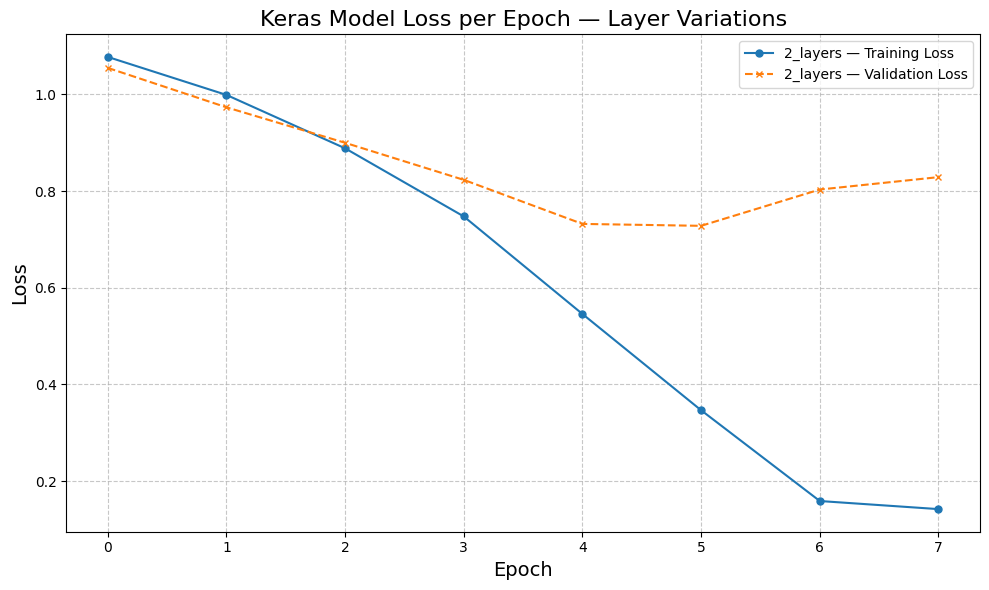

In [6]:
layer_configs = {
    '2_layers':[64,64]
}

layer_results = []
for name, units in layer_configs.items():
    set_global_seed(42)
    K.clear_session()
    model = build_keras_lstm(
        vocab_size=MAX_TOKENS,
        embedding_dim=128,
        seq_len=SEQ_LEN,
        lstm_units=units,
        dropout_rate=0.5,
        bidirectional=True,
        num_classes=len(set(train_labels))
    )
    es = callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    hist = model.fit(
        train_ds, validation_data=val_ds,
        epochs=10, callbacks=[es], verbose=0
    )

    print("Evaluating Keras model on test set...")
    loss, keras_acc = model.evaluate(test_seq, np.array(test_labels), verbose=0)
    keras_preds_probs = model.predict(test_seq)
    keras_preds = np.argmax(keras_preds_probs, axis=1)
    
    keras_f1 = compute_macro_f1_score(np.array(test_labels), keras_preds)
    
    print(f"Keras Model - Test Accuracy: {keras_acc:.4f}, Test F1-score: {keras_f1:.4f}")

   
    path = f'./model_keras_{name}.h5' 
    try:
        model.save(path)
        print(f"Keras model saved to {path}")
    except Exception as e:
        print(f"Error saving model {path}: {e}")

    layer_results.append({
        'config': name,
        'keras_acc': keras_acc,
        'keras_f1': keras_f1,
        'history': hist.history
    })

print("\n--- Results ---")
df_layers = pd.DataFrame(layer_results)[['config', 'keras_acc', 'keras_f1']].set_index('config')
print("\nPerformance Metrics (Keras Models):")
try:
    from IPython.display import display
    display(df_layers)
except ImportError:
    print(df_layers)


print("\nPlotting loss curves...")
plt.figure(figsize=(10, 6)) 
for r in layer_results:
    train_loss = r['history']['loss']
    val_loss   = r['history']['val_loss']

    plt.plot(train_loss, marker='o', linestyle='-', markersize=5,
             label=f"{r['config']} — Training Loss")
    plt.plot(val_loss,   marker='x', linestyle='--', markersize=5,
             label=f"{r['config']} — Validation Loss")

plt.title("Keras Model Loss per Epoch — Layer Variations", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

